In [81]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

# import jax.numpy as np

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')

## autoreload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
class DoubleGyre:
    def __init__(self, a=0.1, eps=0.25, omega=np.pi/5):
        self.a = a
        self.eps = eps
        self.omega = omega
    
    def __call__(self, t, u):
        x, y, z = u
        a = self.eps * np.sin(z)
        b = 1 - 2 * self.eps * np.sin(z)
        f = a * x**2 + b * x
        dx = -self.a * np.pi * np.sin(np.pi * f) * np.cos(np.pi * y)
        dy = self.a * np.pi * np.cos(np.pi * f) * np.sin(np.pi * y) * (2 * a * x + b)
        dz = self.omega
        return np.array([dx, dy, dz])
    

def compress_sequence(word):
    """
    Returns a compressed version of a sequence of labels, in which all runs of the same 
    label are replaced by a single instance of that label.
    """
    compressed_word = []
    for i, label in enumerate(word):
        if i == 0 or label != compressed_word[-1]:
            compressed_word.append(label)
    return np.array(compressed_word)


In [85]:


from scipy.integrate import solve_ivp

eq = ABCFlow()

t_span = [0, 10]
t_span = [0, 100]
num_points = 100

# random initial conditions
# ic_vals = np.array([2, 1, 0]) * np.random.rand(num_points, 3)

# uniform initial conditions over the domain with meshgrid
nx, ny = int(np.sqrt(num_points)), int(np.sqrt(num_points))
x = np.linspace(0, 1, nx + 2)[1:-1]
y = np.linspace(0, 1, ny + 2)[1:-1]
z = np.linspace(0, 1, nx + 2)[1:-1]
x, y, z = np.meshgrid(x, y, z)
ic_vals = np.array([x.flatten(), y.flatten(), z.flatten()]).T

all_trajectories = []
for i in range(len(ic_vals)):
    u0 = ic_vals[i]
    sol = solve_ivp(eq, t_span, u0, t_eval=np.linspace(t_span[0], t_span[-1], 1000), method='Radau')
    all_trajectories.append(sol.y)
all_trajectories = np.array(all_trajectories)
all_trajectories[:, 0] = np.sin(all_trajectories[:, 0])
all_trajectories[:, 1] = np.cos(all_trajectories[:, 1])
all_trajectories[:, 2] = np.sin(all_trajectories[:, 2])

# all_trajectories = np.array(all_trajectories)[..., -500:] # discard transient
all_ic = all_trajectories[:, :, 0]

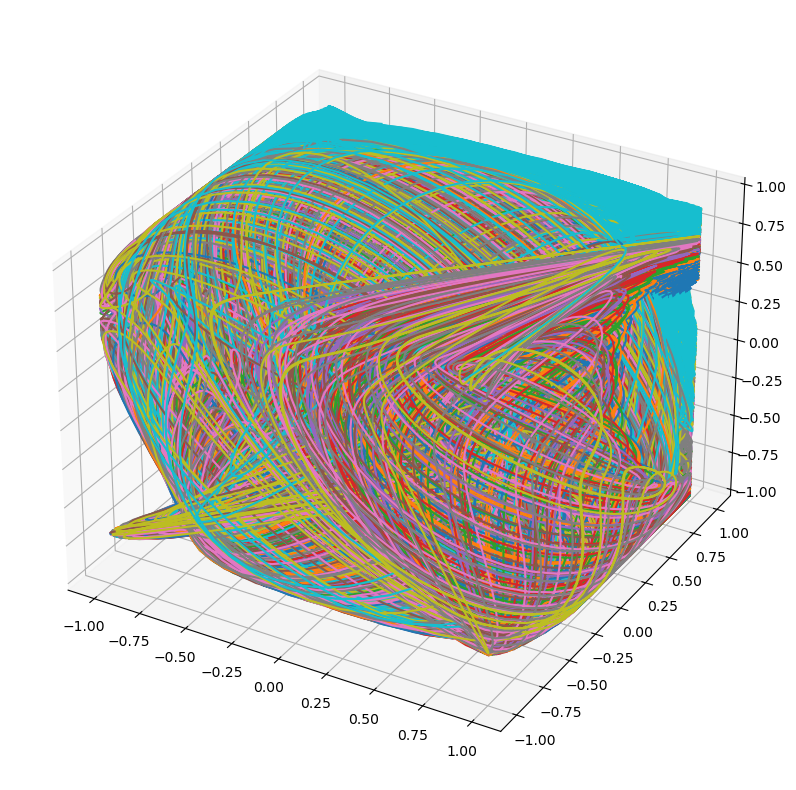

In [ ]:
# 3d trajectories plot

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
# ax = fig.gca(projection='3d')TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'
ax = fig.add_subplot(111, projection='3d')
for traj in all_trajectories:
    ax.plot(*traj, '-')



## Things that remove edge effects

+ Longer trajectories (more crossings dilutes out the effect)

+ Fig 1: Diagram of method
+ Double Gyre flow, bundle of trajectories overlaid. Diagram of a tree parse. Diagram of sensors

+ Fig 2: performance on various flows
+ ABC flow
+ Compare to equivalent FTLE calculation
+ Other common methods in SI

+ Fig 3: Sample sparsity / phase diagram / some basic theoretical model
+ + Control parameters: Symbol budget, noise level, XXX
+ + Analytic work: Each timepoint comprises a decision. The number of choices is proportional to the local Lyapunov exponent. The FTLE of a given point is the product of a series of choices


Lyapunov exponent: rate of decision making


We think of the flow as a series of chaotic hops on symbol space. 
+ The number of decisions is proportional to the local Lyapunov exponent
+ The rate of traversal is proportional to the local velocity and thus Reynolds number
FTLE is the product of a series of decisions.

+ Coarse graining decreases the decision rate. In an advection-dominated regime, it decreases proportional to the length scale of the coarse-graining partition.




(-0.09995401631392165,
 2.0999253773206767,
 -0.04997943069210916,
 1.04960865256608)

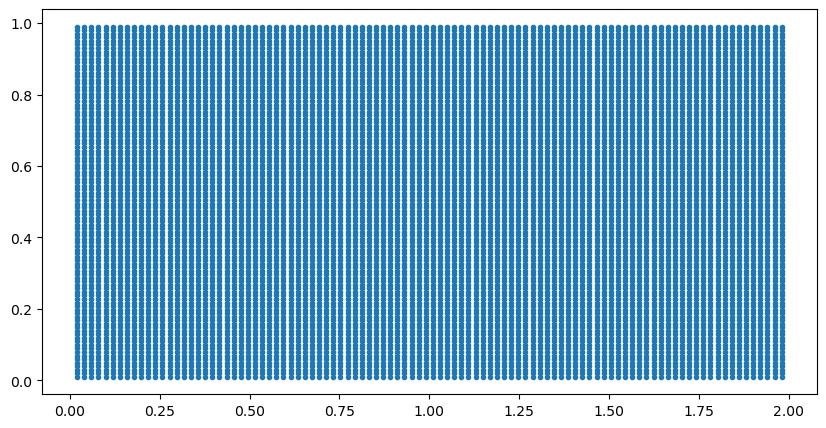

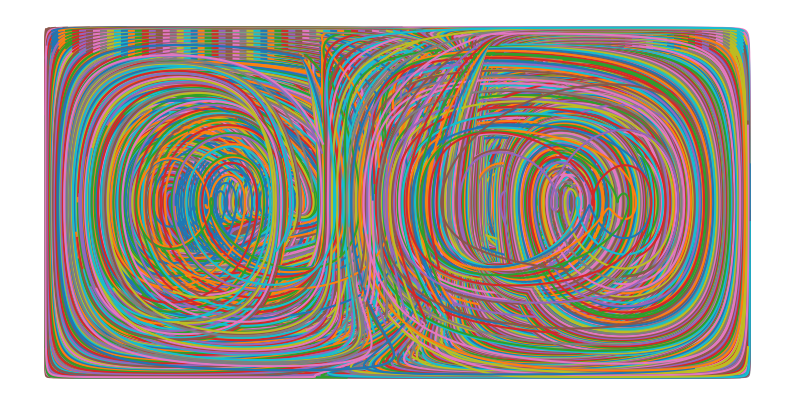

In [88]:
from scipy.integrate import solve_ivp

eq = DoubleGyre()
t_span = [0, 10]
t_span = [0, 20]
num_points = 10000

# random initial conditions
# ic_vals = np.array([2, 1, 0]) * np.random.rand(num_points, 3)

# uniform initial conditions over the domain with meshgrid
nx, ny = int(np.sqrt(num_points)), int(np.sqrt(num_points))
x = np.linspace(0, 2, nx + 2)[1:-1]
y = np.linspace(0, 1, ny + 2)[1:-1]
x, y = np.meshgrid(x, y)
ic_vals = np.array([x.flatten(), y.flatten(), np.zeros_like(x.flatten())]).T

all_trajectories = []
for i in range(len(ic_vals)):
    u0 = ic_vals[i]
    sol = solve_ivp(eq, t_span, u0, t_eval=np.linspace(t_span[0], t_span[-1], 1000), method='Radau')
    all_trajectories.append(sol.y)

# all_trajectories = np.array(all_trajectories)[..., -500:] # discard transient
all_trajectories = np.array(all_trajectories)
all_ic = all_trajectories[:, :, 0]

# all_trajectories2 = all_trajectories + np.random.randn(*all_trajectories.shape) * np.array([1, 1, 0.0])[None, :, None] * 0.01
# all_trajectories2[:, 0, :] = np.clip(all_trajectories2[:, 0, :], 1e-6, 2 - 1e-6)
# all_trajectories2[:, 1, :] = np.clip(all_trajectories2[:, 1, :], 1e-6, 1 - 1e-6)
# all_trajectories = all_trajectories2.copy()

plt.figure(figsize=(10, 5))
plt.plot(all_ic[:, 0], all_ic[:, 1], '.')

plt.figure(figsize=(10, 5))
plt.plot(all_trajectories[:, 0, :].T, all_trajectories[:, 1, :].T);
plt.axis('off')

In [ ]:

from scipy.spatial.distance import cdist

def assign_labels(centroids, points, probabilistic=False):
    """
    Assigns a label to each point based on the closest centroid.
    
    :param centroids: An (M, D) array where M is the number of centroids and D is the dimensionality.
    :param points: An (N, D) array where N is the number of points and D is the dimensionality.
    :param probabilistic: If True, assigns labels probabilistically.
    :return: An array of labels.
    """
    # Calculate the distance from each point to each centroid
    distances = cdist(points, centroids, metric='euclidean')

    if probabilistic:
        # Convert distances to probabilities (inversely proportional to the distance)
        # Use a small epsilon to avoid division by zero
        epsilon = 1e-10
        inverse_distances = 1 / (distances + epsilon)
        # Normalize to get probabilities
        probabilities = inverse_distances / inverse_distances.sum(axis=1, keepdims=True)
        # Choose labels based on the probabilities
        labels = [np.random.choice(len(centroids), p=prob) for prob in probabilities]
    else:
        # Assign the label of the closest centroid
        labels = np.argmin(distances, axis=1)
    
    return np.array(labels)


centroid_locations = np.array([[1.5, 0.5, 0], [0.5, 0.5, 0]])
labels = assign_labels(centroid_locations, all_ic, probabilistic=True)
all_labels = np.array([assign_labels(centroid_locations, all_trajectories[..., i], probabilistic=True) for i in range(all_trajectories.shape[-1])]).T
traj_multiindex = all_labels.copy()
traj_multiindex = [compress_sequence(word) for word in traj_multiindex]


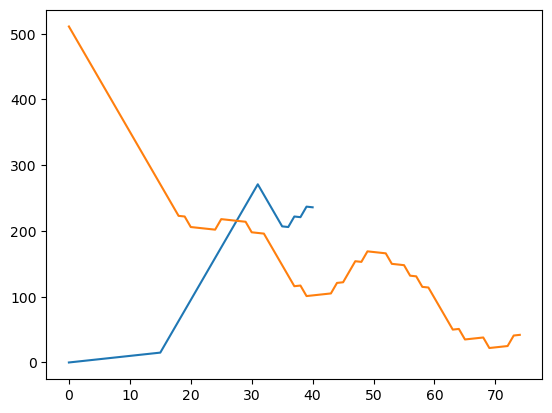

In [ ]:
import numpy as np

def bin_trajectories(trajectories, xbins, ybins):
    xbins = np.array(xbins)
    ybins = np.array(ybins)
    x = trajectories[:, 0, :]
    y = trajectories[:, 1, :]
    
    # Digitize the x and y coordinates
    xdigitized = np.digitize(x, xbins) - 1  # Subtract 1 to make indices 0-based
    ydigitized = np.digitize(y, ybins) - 1  # Subtract 1 to make indices 0-based

    # Combine the digitized indices into a single index
    multi_index = np.ravel_multi_index((xdigitized, ydigitized), (len(xbins) - 1, len(ybins) - 1))
    
    return xdigitized, ydigitized, multi_index




# Assuming all_trajectories is defined properly with the correct shape
# (N, 2, T) where N is number of trajectories, 2 is for x and y, and T is for time steps
# x_edges = np.linspace(0, 2, 5)
# y_edges = np.linspace(0, 1, 3)

# x_edges = np.linspace(0, 2, 4+1)
# y_edges = np.linspace(0, 1, 2+1)

# x_edges = np.linspace(0, 2, 2+1)
# y_edges = np.linspace(0, 1, 1+1)

# x_edges = np.linspace(0, 2, 8+1)
# y_edges = np.linspace(0, 1, 4+1)

# x_edges = np.linspace(0, 2, 16+1)
# y_edges = np.linspace(0, 1, 8+1)


x_edges = np.linspace(0, 2, 32+1)
y_edges = np.linspace(0, 1, 16+1)

xdigitized, ydigitized, traj_multiindex = bin_trajectories(all_trajectories, x_edges, y_edges)

traj_multiindex = [compress_sequence(word) for word in traj_multiindex]


plt.plot(traj_multiindex[0])
plt.plot(traj_multiindex[-1])

In [ ]:
class STree():
    """Class representing the suffix tree."""

    def __init__(self, input=''):
        self.root = _SNode()
        self.root.depth = 0
        self.root.idx = 0
        self.root.parent = self.root
        self.root._add_suffix_link(self.root)

        if not input == '':
            self.build(input)

    def _check_input(self, input):
        """Checks the validity of the input.

        In case of an invalid input throws ValueError.
        """
        if isinstance(input, str):
            return 'st'
        elif isinstance(input, list):
            if all(isinstance(item, str) for item in input):
                return 'gst'

        raise ValueError("String argument should be of type String or a list of strings")

    def build(self, x):
        """Builds the Suffix tree on the given input.
        If the input is of type List of Strings:
        Generalized Suffix Tree is built.

        :param x: String or List of Strings
        """
        type = self._check_input(x)

        if type == 'st':
            x += next(self._terminalSymbolsGenerator())
            self._build(x)
        if type == 'gst':
            self._build_generalized(x)

    def _build(self, x):
        """Builds a Suffix tree."""
        self.word = x
        self._build_McCreight(x)

    def _build_McCreight(self, x):
        """Builds a Suffix tree using McCreight O(n) algorithm.

        Algorithm based on:
        McCreight, Edward M. "A space-economical suffix tree construction algorithm." - ACM, 1976.
        Implementation based on:
        UH CS - 58093 String Processing Algorithms Lecture Notes
        """
        u = self.root
        d = 0
        for i in range(len(x)):
            while u.depth == d and u._has_transition(x[d + i]):
                u = u._get_transition_link(x[d + i])
                d = d + 1
                while d < u.depth and x[u.idx + d] == x[i + d]:
                    d = d + 1
            if d < u.depth:
                u = self._create_node(x, u, d)
            self._create_leaf(x, i, u, d)
            if not u._get_suffix_link():
                self._compute_slink(x, u)
            u = u._get_suffix_link()
            d = d - 1
            if d < 0:
                d = 0

    def _create_node(self, x, u, d):
        i = u.idx
        p = u.parent
        v = _SNode(idx=i, depth=d)
        v._add_transition_link(u, x[i + d])
        u.parent = v
        p._add_transition_link(v, x[i + p.depth])
        v.parent = p
        return v

    def _create_leaf(self, x, i, u, d):
        w = _SNode()
        w.idx = i
        w.depth = len(x) - i
        u._add_transition_link(w, x[i + d])
        w.parent = u
        return w

    def _compute_slink(self, x, u):
        d = u.depth
        v = u.parent._get_suffix_link()
        while v.depth < d - 1:
            v = v._get_transition_link(x[u.idx + v.depth + 1])
        if v.depth > d - 1:
            v = self._create_node(x, v, d - 1)
        u._add_suffix_link(v)

    def _build_Ukkonen(self, x):
        """Builds a Suffix tree using Ukkonen's online O(n) algorithm.

        Algorithm based on:
        Ukkonen, Esko. "On-line construction of suffix trees." - Algorithmica, 1995.
        """
        # TODO.
        raise NotImplementedError()

    def _build_generalized(self, xs):
        """Builds a Generalized Suffix Tree (GST) from the array of strings provided.
        """
        terminal_gen = self._terminalSymbolsGenerator()

        _xs = ''.join([x + next(terminal_gen) for x in xs])
        self.word = _xs
        self._generalized_word_starts(xs)
        self._build(_xs)
        self.root._traverse(self._label_generalized)

    def _label_generalized(self, node):
        """Helper method that labels the nodes of GST with indexes of strings
        found in their descendants.
        """
        if node.is_leaf():
            x = {self._get_word_start_index(node.idx)}
        else:
            x = {n for ns in node.transition_links.values() for n in ns.generalized_idxs}
        node.generalized_idxs = x

    def _get_word_start_index(self, idx):
        """Helper method that returns the index of the string based on node's
        starting index"""
        i = 0
        for _idx in self.word_starts[1:]:
            if idx < _idx:
                return i
            else:
                i += 1
        return i

    def lcs(self, stringIdxs=-1):
        """Returns the Largest Common Substring of Strings provided in stringIdxs.
        If stringIdxs is not provided, the LCS of all strings is returned.

        ::param stringIdxs: Optional: List of indexes of strings.
        """
        if stringIdxs == -1 or not isinstance(stringIdxs, list):
            stringIdxs = set(range(len(self.word_starts)))
        else:
            stringIdxs = set(stringIdxs)

        deepestNode = self._find_lcs(self.root, stringIdxs)
        start = deepestNode.idx
        end = deepestNode.idx + deepestNode.depth
        return self.word[start:end]

    def _find_lcs(self, node, stringIdxs):
        """Helper method that finds LCS by traversing the labeled GSD."""
        nodes = [self._find_lcs(n, stringIdxs)
                 for n in node.transition_links.values()
                 if n.generalized_idxs.issuperset(stringIdxs)]

        if nodes == []:
            return node

        deepestNode = max(nodes, key=lambda n: n.depth)
        return deepestNode

    def _generalized_word_starts(self, xs):
        """Helper method returns the starting indexes of strings in GST"""
        self.word_starts = []
        i = 0
        for n in range(len(xs)):
            self.word_starts.append(i)
            i += len(xs[n]) + 1

    def find(self, y):
        """Returns starting position of the substring y in the string used for
        building the Suffix tree.

        :param y: String
        :return: Index of the starting position of string y in the string used for building the Suffix tree
                 -1 if y is not a substring.
        """
        counter = 0
        node = self.root
        while True:
            edge = self._edgeLabel(node, node.parent)
            if edge.startswith(y):
                return node.idx, counter

            i = 0
            while (i < len(edge) and edge[i] == y[0]):
                y = y[1:]
                i += 1

            if i != 0:
                if i == len(edge) and y != '':
                    pass
                else:
                    return -1

            node = node._get_transition_link(y[0])
            counter += 1
            if not node:
                return -1
                
    # def find_string_depth(self, s):
    #     node = self.root
    #     depth = 0

    #     while s:
    #         edge_label, next_node = None, None
    #         # Find the edge to traverse next
    #         for key in node.transition_links:
    #             if s.startswith(key):
    #                 edge_label = key
    #                 next_node = node.transition_links[key]
    #                 break

    #         if next_node is None:
    #             return -1  # The string does not exist in the tree.
    #         else:
    #             depth += len(edge_label)
    #             s = s[len(edge_label):]
    #             node = next_node
    #     return depth





    def find_all(self, y):
        node = self.root
        while True:
            edge = self._edgeLabel(node, node.parent)
            if edge.startswith(y):
                break

            i = 0
            while (i < len(edge) and edge[i] == y[0]):
                y = y[1:]
                i += 1

            if i != 0:
                if i == len(edge) and y != '':
                    pass
                else:
                    return {}

            node = node._get_transition_link(y[0])
            if not node:
                return {}

        leaves = node._get_leaves()
        return {n.idx for n in leaves}

    def _edgeLabel(self, node, parent):
        """Helper method, returns the edge label between a node and it's parent"""
        return self.word[node.idx + parent.depth: node.idx + node.depth]

    def _terminalSymbolsGenerator(self):
        """Generator of unique terminal symbols used for building the Generalized Suffix Tree.
        Unicode Private Use Area U+E000..U+F8FF is used to ensure that terminal symbols
        are not part of the input string.
        """
        UPPAs = list(list(range(0xE000, 0xF8FF+1)) +
                     list(range(0xF0000, 0xFFFFD+1)) + list(range(0x100000, 0x10FFFD+1)))
        for i in UPPAs:
            yield (chr(i))

        raise ValueError("To many input strings.")


class _SNode():
    __slots__ = ['_suffix_link', 'transition_links', 'idx', 'depth', 'parent', 'generalized_idxs']

    """Class representing a Node in the Suffix tree."""

    def __init__(self, idx=-1, parentNode=None, depth=-1):
        # Links
        self._suffix_link = None
        self.transition_links = {}
        # Properties
        self.idx = idx
        self.depth = depth
        self.parent = parentNode
        self.generalized_idxs = {}

    def __str__(self):
        return ("SNode: idx:" + str(self.idx) + " depth:" + str(self.depth) +
                " transitons:" + str(list(self.transition_links.keys())))

    def _add_suffix_link(self, snode):
        self._suffix_link = snode

    def _get_suffix_link(self):
        if self._suffix_link is not None:
            return self._suffix_link
        else:
            return False

    def _get_transition_link(self, suffix):
        return False if suffix not in self.transition_links else self.transition_links[suffix]

    def _add_transition_link(self, snode, suffix):
        self.transition_links[suffix] = snode

    def _has_transition(self, suffix):
        return suffix in self.transition_links

    def is_leaf(self):
        return len(self.transition_links) == 0

    def _traverse(self, f):
        for node in self.transition_links.values():
            node._traverse(f)
        f(self)

    def _get_leaves(self):
        # Python <3.6 dicts don't perserve insertion order (and even after, we
        # shouldn't rely on dicts perserving the order) therefore these can be
        # out-of-order, so we return a set of leaves.
        if self.is_leaf():
            return {self}
        else:
            return {x for n in self.transition_links.values() for x in n._get_leaves()}

(array([  21.,  163.,  778., 1942., 2737., 2235., 1406.,  539.,  164.,
          15.]),
 array([ 5. ,  7.9, 10.8, 13.7, 16.6, 19.5, 22.4, 25.3, 28.2, 31.1, 34. ]),
 <BarContainer object of 10 artists>)

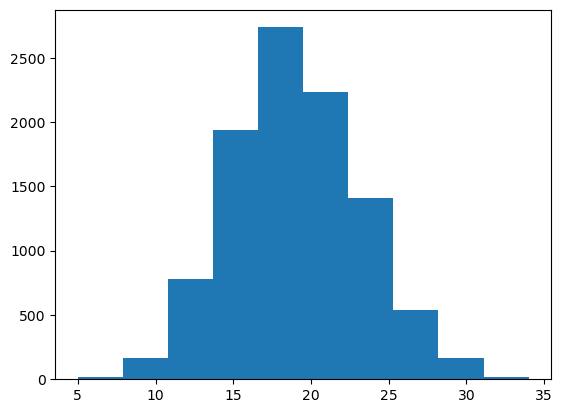

In [ ]:


all_trajectories_str = [''.join(map(str, traj)) for traj in traj_multiindex]


# take a random 4800 sequential characters
# all_trajectories_str2 = list()
# for traj in all_trajectories_str:
#     start_idx = np.random.randint(100)
#     all_trajectories_str2.append(traj[start_idx:start_idx+4800])
# all_trajectories_str = all_trajectories_str2.copy()

## append a unique end symbol to each string
# unique_end_symbols = ['${}'.format(i) for i in range(len(all_trajectories))]
# all_trajectories_str = [''.join(map(str, traj)) + end_symbol for traj, end_symbol in zip(all_trajectories_str, unique_end_symbols)]


st = STree(all_trajectories_str)
path_lengths = [st.find(traj)[1] for traj in all_trajectories_str]

plt.hist(path_lengths)

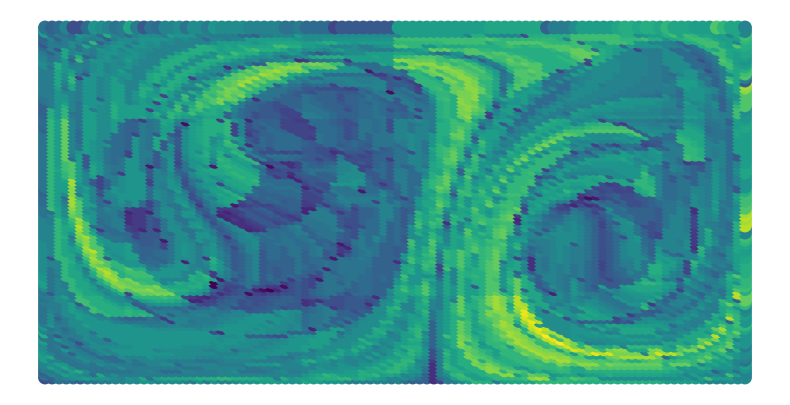

In [ ]:
# first symbol trimmed off helps
plt.figure(figsize=(10, 5))
plt.scatter(ic_vals[:, 0], ic_vals[:, 1], c=np.array(path_lengths), cmap='viridis', s=80)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().set_axis_off()
plt.gca().axes.set_aspect("equal")

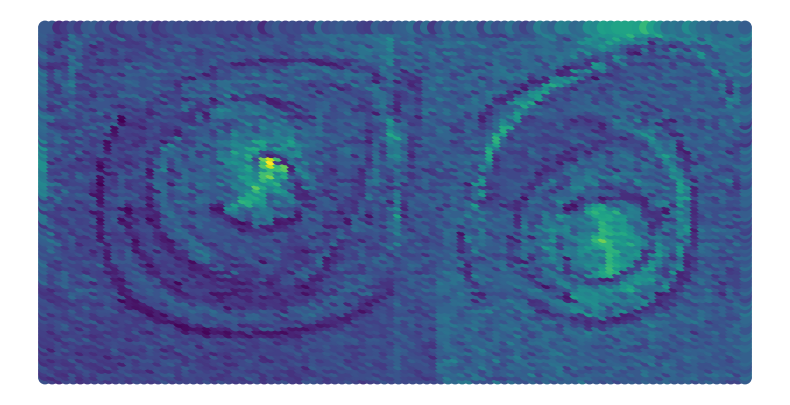

In [ ]:
# noisier
plt.figure(figsize=(10, 5))
plt.scatter(ic_vals[:, 0], ic_vals[:, 1], c=np.array(path_lengths), cmap='viridis', s=80)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().set_axis_off()
plt.gca().axes.set_aspect("equal")

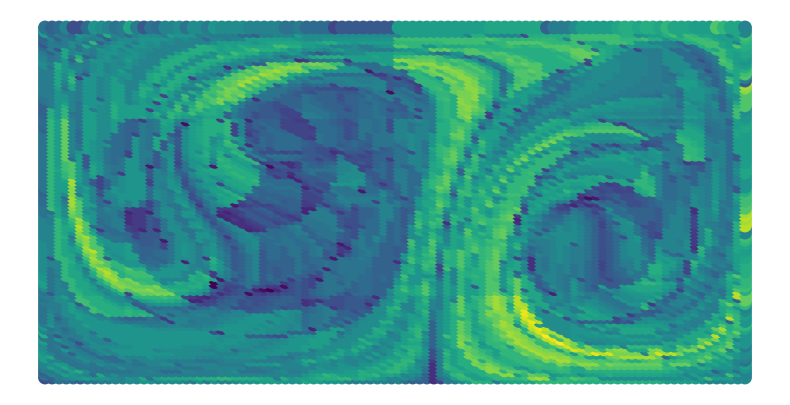

In [ ]:
# first symbol trimmed off helps
plt.figure(figsize=(10, 5))
plt.scatter(ic_vals[:, 0], ic_vals[:, 1], c=np.array(path_lengths), cmap='viridis', s=80)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().set_axis_off()
plt.gca().axes.set_aspect("equal")

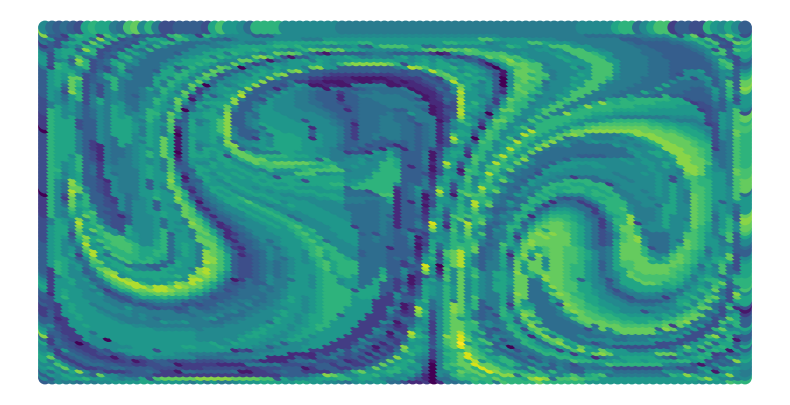

In [ ]:
# first symbol trimmed off helps
plt.figure(figsize=(10, 5))
plt.scatter(ic_vals[:, 0], ic_vals[:, 1], c=np.array(path_lengths), cmap='viridis', s=80)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().set_axis_off()
plt.gca().axes.set_aspect("equal")

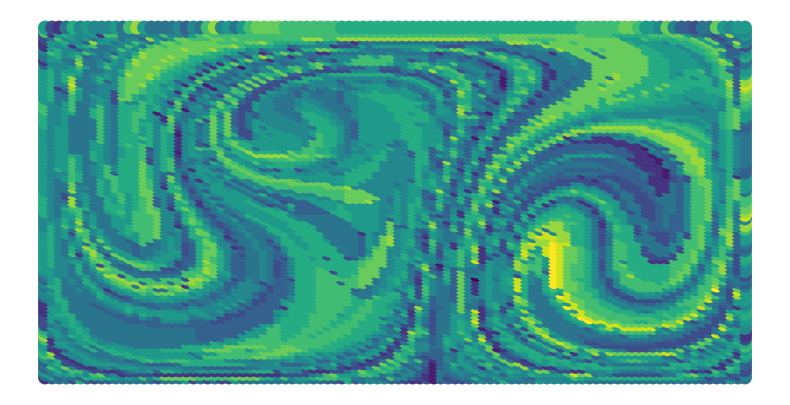

In [ ]:
# backwards
plt.figure(figsize=(10, 5))
plt.scatter(ic_vals[:, 0], ic_vals[:, 1], c=np.array(path_lengths), cmap='viridis', s=80)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().set_axis_off()
plt.gca().axes.set_aspect("equal")

In [ ]:
7*7

49

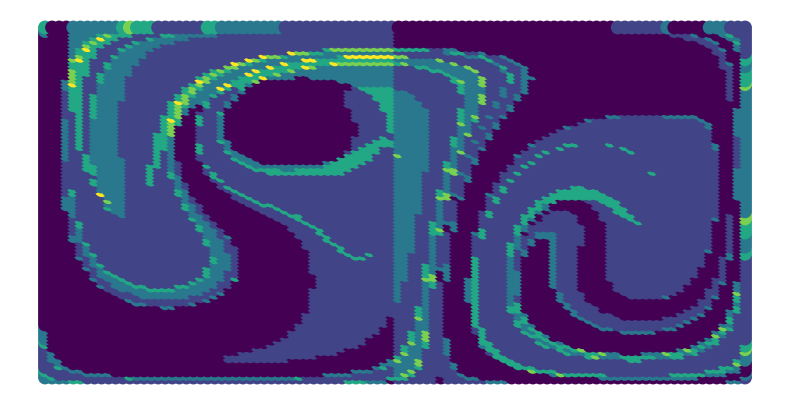

In [ ]:
# first symbol trimmed off helps
plt.figure(figsize=(10, 5))
plt.scatter(ic_vals[:, 0], ic_vals[:, 1], c=np.array(path_lengths), cmap='viridis', s=80)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().set_axis_off()
plt.gca().axes.set_aspect("equal")

(array([  34.,  129.,  456.,  793., 1084., 1523.,  532.,  203.,  115.,
          31.]),
 array([  3. ,  46.9,  90.8, 134.7, 178.6, 222.5, 266.4, 310.3, 354.2,
        398.1, 442. ]),
 <BarContainer object of 10 artists>)

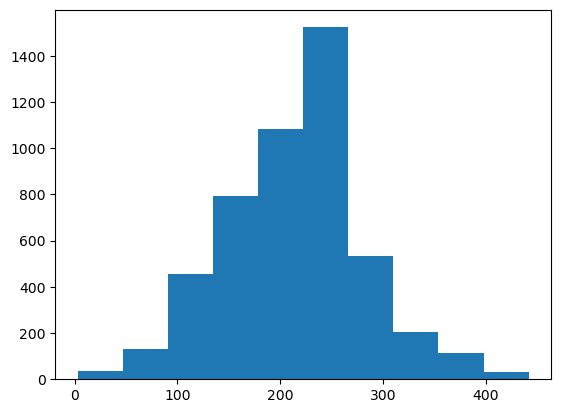

In [ ]:
def trim_initial_symbol(word):
    char = word[0]
    for i in range(1, len(word)):
        if word[i] != char:
            return word[i:]
    return word

all_trajectories_str = [''.join(map(str, traj)) for traj in traj_multiindex]
all_trajectories_str = [trim_initial_symbol(traj) for traj in all_trajectories_str]

st = STree(all_trajectories_str)
path_lengths = [st.find(traj)[1] for traj in all_trajectories_str]

plt.hist(path_lengths)

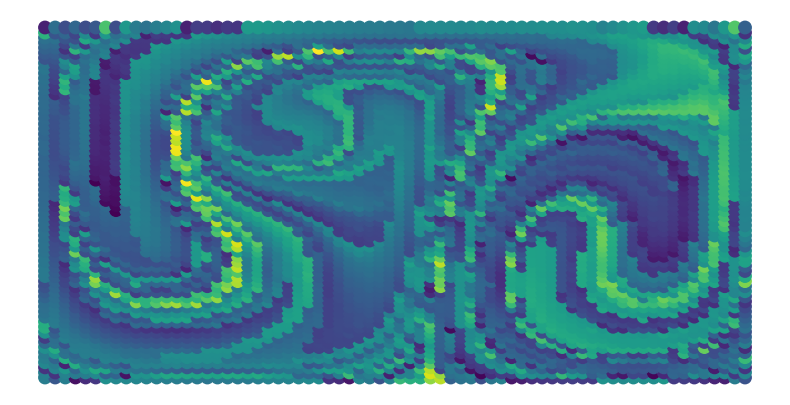

In [ ]:
# backwards strings
plt.figure(figsize=(10, 5))
plt.scatter(ic_vals[:, 0], ic_vals[:, 1], c=np.array(path_lengths), cmap='viridis', s=80)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().set_axis_off()
plt.gca().axes.set_aspect("equal")

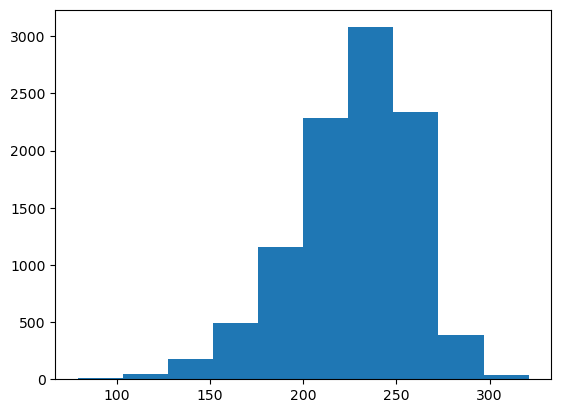

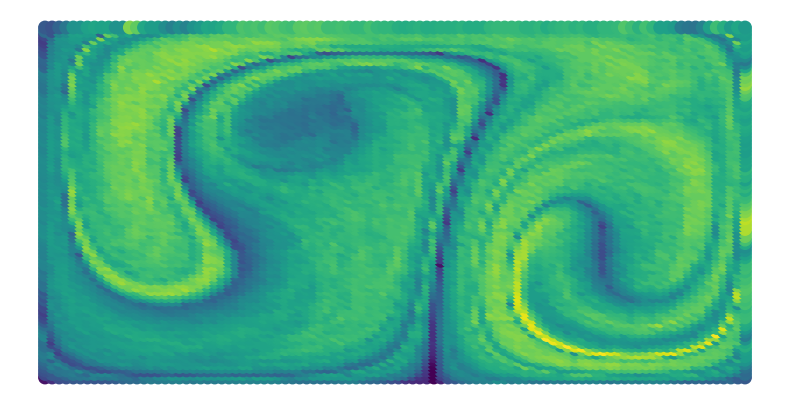

In [ ]:
from suffix_tree import Tree

all_trajectories_str = [''.join(map(str, traj)) for traj in traj_multiindex]

tree = Tree()
for i, word in enumerate(all_trajectories_str):
    tree.add(i, word)

path_lengths2 = [tree.find(traj_str, return_depth=True)[1] for traj_str in all_trajectories_str]
plt.hist(path_lengths2)

plt.figure(figsize=(10, 5))
plt.scatter(ic_vals[:, 0], ic_vals[:, 1], c=path_lengths2, cmap='viridis', s=80)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().set_axis_off()
plt.gca().axes.set_aspect("equal")

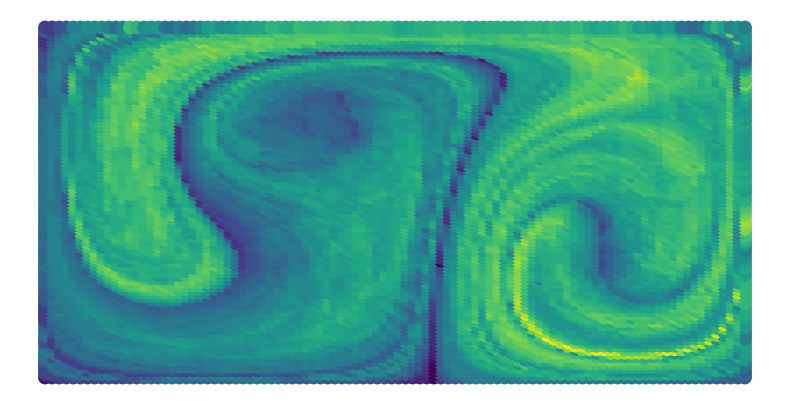

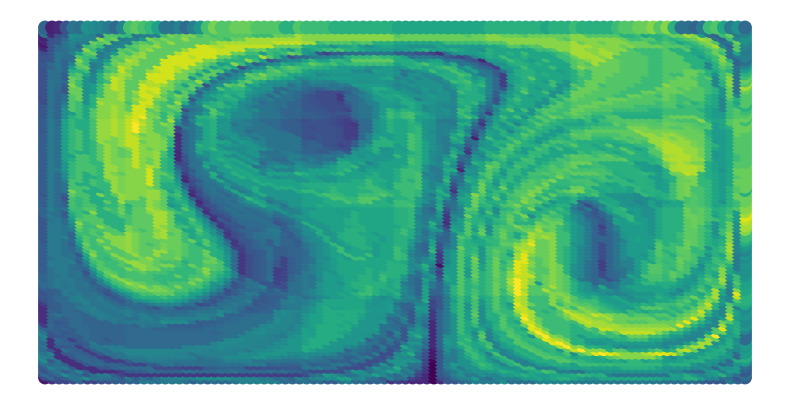

In [ ]:
print(path_lengths[:3])

[22, 18, 14]


In [ ]:
tree2 = Tree({"A": "xabxac"})
path_info = tree2.find('abx')

In [ ]:
for C, path in sorted(tree.maximal_repeats()):
    print(C, path)
    break

1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [ ]:
for k, length, path in tree.common_substrings()[:3]:
    print(k, length, path)

2 713 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 